In [19]:
# imports
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
from torch.optim import Adam
from models.models import NaiveMLP
from utils.data import PatientDataset
from utils.train import naive_train, noisy_train, timeseries_MSE_loss, timeseries_L2_loss, timeseries_H1_loss

In [20]:
HIDDEN_LAYERS = 3
NUM_EPOCHS = 1000
PRINT_EVERY = 1
LEARNING_RATE = 1e-3
BATCH_SIZE = 10
WANDB = False
NET_NAME = "naive_mlp_test"
DT = 1.
NOISE_VAR = 0.01


In [21]:
# data
health_data_file = "/Users/wlao/Documents/Homework/dsml_final_project/data/heart_failure_clinical_records_dataset.csv"
survival_file = "/Users/wlao/Documents/Homework/dsml_final_project/data/survival_function_data.csv"

train_split = 90
num_patients = 299
ids = np.random.permutation(num_patients)
split_id = int((num_patients*train_split)//100)
train_ids = ids[:split_id]
test_ids = ids[split_id:]

train_dataset = PatientDataset(health_data_file, survival_file, train_ids)
test_dataset = PatientDataset(health_data_file, survival_file, test_ids)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE)

sample = next(iter(train_loader))
print(len(sample))
xs, ys = sample
print([x.shape for x in xs])
print([y.shape for y in ys])

2
[torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13]), torch.Size([13])]
[torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285]), torch.Size([285])]


In [22]:
# model and optimizer
model = NaiveMLP(13,320,285,HIDDEN_LAYERS)
optimizer = Adam(model.parameters(), LEARNING_RATE)


In [23]:
loss_fn = timeseries_H1_loss
save_dir = "/Users/wlao/Documents/Homework/dsml_final_project/saved_models"
noisy_train(model, optimizer, train_loader, test_loader, NUM_EPOCHS, loss_fn, WANDB, NET_NAME, PRINT_EVERY, save_dir, DT, NOISE_VAR)

Epoch: 0   Train: 7.836609248761778 (2.980167865753174)    Test: 31.626489877700806
Epoch: 1   Train: 2.9191240734524198 (0.7617456912994385)    Test: 19.83694114287694
Epoch: 2   Train: 2.0663900529896773 (1.352134108543396)    Test: 16.886124690373737
Epoch: 3   Train: 1.8750524145585519 (2.387648820877075)    Test: 16.2294845978419
Epoch: 4   Train: 1.7240467402670119 (2.6324827671051025)    Test: 15.588618199030558
Epoch: 5   Train: 1.7414368236506428 (1.7190883159637451)    Test: 16.733540693918865
Epoch: 6   Train: 1.5668586095174153 (2.318636894226074)    Test: 14.21153481801351
Epoch: 7   Train: 1.4055970355316445 (1.030390739440918)    Test: 13.08349460363388
Epoch: 8   Train: 1.0562686257892184 (1.1598286628723145)    Test: 11.714363992214203
Epoch: 9   Train: 1.1202247087602262 (1.1918691396713257)    Test: 8.529036432504654
Epoch: 10   Train: 0.6763263808356391 (0.5002245306968689)    Test: 12.606276869773865
Epoch: 11   Train: 0.9050714417740151 (0.639549970626831)    Test

KeyboardInterrupt: 

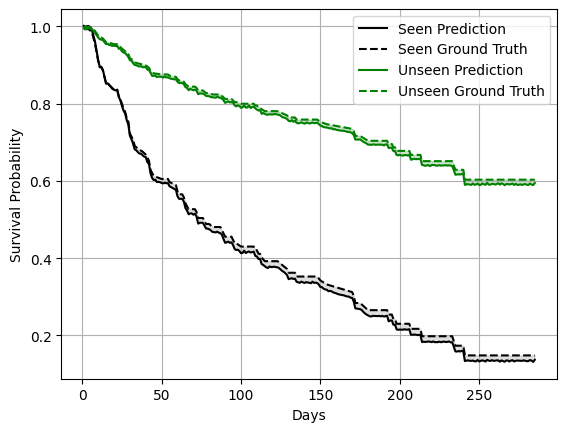

In [34]:
# inference
seen_patient, seen_truth = train_dataset[22]
unseen_patient, unseen_truth = test_dataset[4]

seen_pred = model(seen_patient)
unseen_pred = model(unseen_patient)

seen_truth = seen_truth.detach().numpy()
unseen_truth = unseen_truth.detach().numpy()
seen_pred = seen_pred.detach().numpy()
unseen_pred = unseen_pred.detach().numpy()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
days = np.arange(1,286)
ax.plot(days, seen_pred, "-k", label="Seen Prediction")
ax.plot(days, seen_truth, "--k", label="Seen Ground Truth")
ax.plot(days, unseen_pred, "-g", label="Unseen Prediction")
ax.plot(days, unseen_truth, "--g", label="Unseen Ground Truth")
ax.fill_between(days, np.min(np.asarray([seen_pred, seen_truth]), axis=0), np.max(np.asarray([seen_pred, seen_truth]), axis=0), color="silver", alpha=0.5)
ax.fill_between(days, np.min(np.asarray([unseen_pred, unseen_truth]), axis=0), np.max(np.asarray([unseen_pred, unseen_truth]), axis=0), color="green", alpha=0.2)
plt.grid(True)
ax.set_xlabel("Days")
ax.set_ylabel("Survival Probability")
plt.legend(loc='best')